# PS4: Gradient descent and regularization
This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set so make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using a modified version of the [California Housing Prices Dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html). Please download the csv file from bcourses ('cal_housing_data_clean_ps4.csv'). 

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [2]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

from sklearn.linear_model import Ridge

In [3]:
# Load the California Housing Dataset 
cal_df = pd.read_csv('cal_housing_data_clean_ps4.csv')

# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)

In [4]:
cal_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,DistCoast,Inland,MedHouseVal
0,3.6885,49,5.184569,1.052950,2363,3.574887,4205.460788,0,2.540
1,3.1630,26,4.267241,0.961207,719,3.099138,28060.624020,0,1.794
2,2.8042,35,3.895018,1.080071,1193,2.122776,20913.168450,0,2.409
3,4.2305,32,5.891775,1.235931,2541,5.500000,21878.282810,0,2.214
4,4.7663,38,5.566038,1.015094,827,3.120755,16863.074990,0,1.916


---

# Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between median housing value and median income in California's census block groups. 

(a) Regress the median housing value `MedHouseVal` on the median income `MedInc`. Draw a scatter plot of housing price (y-axis) against income (x-axis), and draw the regression line in blue.  You might want to make the dots semi-transparent if it improves the presentation of the figure. 

(b) Regress the median housing value on median income and median income squared.  Plot this new (curved) regression line in gold, on the same axes used for part (a). 

(c) Interpret your results.

Linear model: alpha = 1.5772617051685813, beta = [0.16400596]
Quadratic model: alpha = 2.1010099852861814, beta = [-0.10678359  0.03153349]


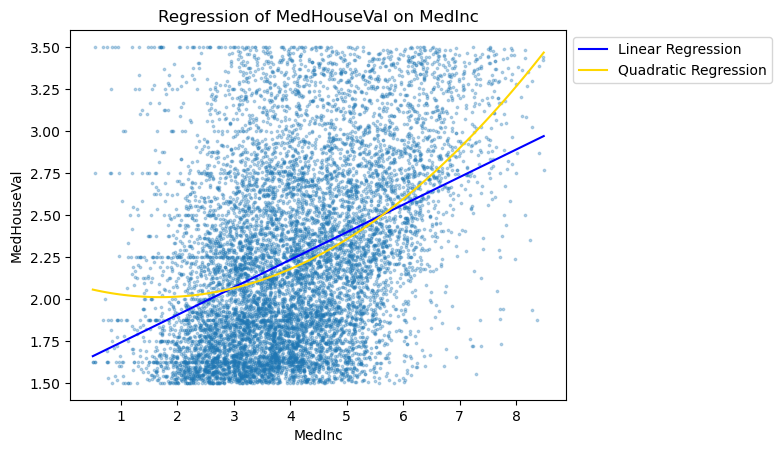

In [111]:
# a
reg = LinearRegression().fit(cal_df['MedInc'].values.reshape(-1,1), cal_df['MedHouseVal'])

plt.scatter(cal_df['MedInc'], cal_df['MedHouseVal'], s = 3, alpha = 0.3)

plt.title('Regression of MedHouseVal on MedInc')
plt.xlabel('MedInc')
plt.ylabel('MedHouseVal')

x_range = np.linspace(cal_df['MedInc'].min(), cal_df['MedInc'].max(), 100).reshape(-1, 1)

reg_pred = reg.predict(x_range)

plt.plot(x_range, reg_pred, color='blue', label='Linear Regression')

# b
reg2 = LinearRegression().fit(np.concatenate((cal_df['MedInc'].values.reshape(-1,1), cal_df['MedInc'].values.reshape(-1,1)**2), axis=1), cal_df['MedHouseVal'])

reg2_pred = reg2.predict(np.concatenate((x_range,x_range**2),axis = 1))

print('Linear model: alpha = {}, beta = {}'.format(reg.intercept_, reg.coef_))
print('Quadratic model: alpha = {}, beta = {}'.format(reg2.intercept_, reg2.coef_))

plt.plot(x_range, reg2_pred, color='gold', label='Quadratic Regression')

plt.legend(bbox_to_anchor = (1, 1))

plt.show()

(c)

According to the graph, there is a positive correlation between MedInc and MedHouseVal in the linear model: with 1 unit increase in MedInc, the MedHouseVal would increase by 0.164. In the quadratic model, the positive correlation still exists, only now that we see that there is variation in the correlation across levels of MedInc, higher MedInc would lead to higher positive correlation between MedInc and MedHouseVal.


### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but if your primary objective is prediction, you should be careful about overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 5-fold cross-validation to fit the regression model (a) from 1.1, i.e. the linear fit of median housing value on median income. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Create a new scatterplot of housing price against rooms, and draw the five different regression lines in light blue, and the original regression line from 1.1 in red (which was estimated using the full dataset). What do you notice?

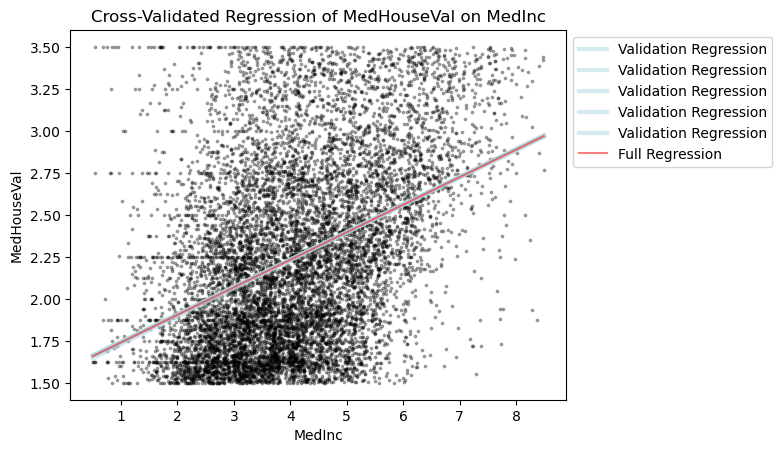

In [105]:
from sklearn.model_selection import KFold

plt.scatter(cal_df['MedInc'], cal_df['MedHouseVal'], color = 'black', s = 3, alpha = 0.3)

plt.title('Cross-Validated Regression of MedHouseVal on MedInc')
plt.xlabel('MedInc')
plt.ylabel('MedHouseVal')

kf = KFold(n_splits=5)

for train, test in kf.split(cal_df['MedInc'].values.reshape(-1,1)):
    reg_temp = LinearRegression().fit(cal_df['MedInc'].values.reshape(-1,1)[train], cal_df['MedHouseVal'][train])

    reg_pred_temp = reg_temp.predict(x_range)
    
    plt.plot(x_range, reg_pred_temp, color='lightblue', label='Validation Regression', lw = 3, alpha = 0.5)



plt.plot(x_range, reg_pred, color='red', label='Full Regression', alpha = 0.5)

plt.legend(bbox_to_anchor = (1, 1))
plt.show()

We could see that the regression line from cross-validated model and full model is very similar.

# Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (median income)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the median house value on the median income. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries in 1.1? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: We recommend including a MaxIterations parameter in their gradient descent algorithm, to make sure things don't go off the rails, i.e., as a safeguard in case your algorithm isn't converging as it should. *

In [112]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    coefficient
"""
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    epsilon = 0.0000001
    alpha = np.mean(yvalues)
    beta = np.mean((yvalues-alpha)/xvalues)
    i = 1

    while i <= MaxIterations:
        alpha_new = alpha - R * np.mean(alpha + beta * xvalues - yvalues)
        beta_new = beta - R * np.mean((alpha + beta * xvalues - yvalues) * xvalues)
        
        if abs(alpha_new-alpha) <= epsilon and abs(beta_new - beta) <= epsilon:
            break
        
        alpha = alpha_new
        beta = beta_new

        i += 1
    

    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('The algorithm converged in {} iterations.'.format(i))

    return alpha, beta


In [113]:
for R in [0.01,0.02,0.05]:
    alpha, beta = bivariate_ols(cal_df['MedInc'], cal_df['MedHouseVal'], R = R, MaxIterations = 10000)
    print('When R is {}: alpha is {}, beta is {}'.format(R, alpha, beta))
    print('')

print('In the sklearn model, alpha is {}, beta is {}'.format(reg.intercept_, reg.coef_[0]))

Time taken: 5.84 seconds
The algorithm converged in 9477 iterations.
When R is 0.01: alpha is 1.5773701486599543, beta is 0.16398180722559497

Time taken: 3.16 seconds
The algorithm converged in 5113 iterations.
When R is 0.02: alpha is 1.5773158786741328, beta is 0.1639938924431602

Time taken: 1.37 seconds
The algorithm converged in 2242 iterations.
When R is 0.05: alpha is 1.5772833099374741, beta is 0.16400114507575966

In the sklearn model, alpha is 1.5772617051685813, beta is 0.16400595617582836


Compare to the ones estimated through sklearn model, my coefficients are fairly close. They do not depend on R but larger R here takes less time/iteration to achieve a close enough coefficient.

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code to standardize your features. 

**For all the following questions, unless explicitly asked otherwise, you are expected to standardize appropriately. Recall that in settings where you are using holdout data for validation or testing purposes, this involves substracting the average and dividing by the standard deviation of your training data.**

In [9]:
'''
Function
--------
standardize
    Column-wise standardization of a target dataframe using the mean and std of a reference dataframe

Parameters
----------
ref,tar : pd.DataFrame
    ref: reference dataframe
    tar: target dataframe
    
Returns
-------
tar_norm: pd.DataFrame
    Standardized target dataframe
'''
def standardize(ref,tar):
    tar_norm = ((tar - np.mean(ref, axis = 0)) / np.std(ref, axis = 0))
    return tar_norm

# Examples
# Standardize train: standardize(ref=x_train,tar=x_train)
# Standardize test: standardize(ref=x_train,tar=x_test)

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Remember to standardize appropriately before inputting them to the gradient descent algorithm. How do your coefficients compare to the ones estimated through standard libraries?

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with three values of R (0.1, 0.01, and 0.001).

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [139]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations

suppress: Boolean
    Default False, do not print out time/iteration taken if True

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    coefficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000, suppress = False):
    start_time = time.time()

    yvalues = yvalues.reshape(-1,1)
    epsilon = 0.00000001



    alpha = np.mean(yvalues)
    beta_array = np.array([[np.mean((yvalues-alpha)/col) for col in xvalue_matrix.T]]).T
    i = 0
    
    while i < MaxIterations:
        alpha_new = alpha - R * np.mean(alpha + np.dot(xvalue_matrix, beta_array) - yvalues)
        beta_array_new = np.empty(beta_array.shape)
        for j in range(len(beta_array)):
            beta_array_new[j] = beta_array[j] - R * np.mean((alpha + np.dot(xvalue_matrix, beta_array) - yvalues) * xvalue_matrix[:,j].reshape(-1,1))
        
        if abs(alpha_new-alpha) <= epsilon and np.all(abs(beta_array_new - beta_array) <= epsilon):
            break
        
        alpha = alpha_new
        beta_array = beta_array_new

        i += 1
    
    if  suppress == False:
        print("Time taken: {:.2f} seconds".format(time.time() - start_time))
        print('The algorithm converged in {} iterations.'.format(i))
    
    return alpha, beta_array

In [140]:
for R in [0.1,0.01,0.001]:
    alpha, beta = multivariate_ols(standardize(cal_df[['MedInc','HouseAge','AveRooms']],cal_df[['MedInc','HouseAge','AveRooms']]).to_numpy(), 
                                   cal_df['MedHouseVal'].to_numpy(), 
                                   R = R, MaxIterations = 100000)
    print('When R is {}: alpha is {}, betas are {}'.format(R, alpha, beta.flatten().tolist()))
    print('')

reg_multi = LinearRegression().fit(standardize(cal_df[['MedInc','HouseAge','AveRooms']],cal_df[['MedInc','HouseAge','AveRooms']]), 
                                   cal_df['MedHouseVal'])

print('In the sklearn model, alpha is {}, betas are {}'.format(reg_multi.intercept_, reg_multi.coef_))


Time taken: 1.82 seconds
The algorithm converged in 223 iterations.
When R is 0.1: alpha is 2.2458724723388017, betas are [0.25448593488475757, 0.08671263088008951, -0.030876270087753763]

Time taken: 2.51 seconds
The algorithm converged in 1912 iterations.
When R is 0.01: alpha is 2.2458724723388017, betas are [0.2544844505602122, 0.08671214030956986, -0.030875078680248778]

Time taken: 7.92 seconds
The algorithm converged in 15354 iterations.
When R is 0.001: alpha is 2.2458724723388017, betas are [0.25446955087844947, 0.08670709255538883, -0.030863224343111232]

In the sklearn model, alpha is 2.2458724723388017, betas are [ 0.2544861   0.08671268 -0.0308764 ]


My coefficients are fairly close to libraries coefficients. Adjusting for R value, we observe the same pattern as in 2.1: larger R value leads to fewer iteration/time needed to converge.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm? Compare to the results you would obtain using standard libraries. 

In [132]:
for R in [0.1,0.01,0.001]:
    alpha, beta = multivariate_ols(cal_df[['MedInc','HouseAge','AveRooms']].to_numpy(), 
                                   cal_df['MedHouseVal'].to_numpy(), 
                                   R = R, MaxIterations = 100000)
    print('When R is {}: alpha is {}, betas are {}'.format(R, alpha, beta.flatten().tolist()))
    print('')

reg_multi = LinearRegression().fit(cal_df[['MedInc','HouseAge','AveRooms']], 
                                   cal_df['MedHouseVal'])

print('In the sklearn model, alpha is {}, betas are {}'.format(reg_multi.intercept_, reg_multi.coef_))

c:\Users\Teddywolf\Desktop\Stat243\yilin-ni\.conda\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Teddywolf\AppData\Local\Temp\ipykernel_22352\3238498371.py:47: RuntimeWarning: invalid value encountered in subtract
  beta_array_new[j] = beta_array[j] - R * np.mean((alpha + np.dot(xvalue_matrix, beta_array) - yvalues) * xvalue_matrix[:,j].reshape(-1,1))


Time taken: 27.23 seconds
The algorithm converged in 100000 iterations.
When R is 0.1: alpha is nan, betas are [nan, nan, nan]



c:\Users\Teddywolf\Desktop\Stat243\yilin-ni\.conda\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Teddywolf\AppData\Local\Temp\ipykernel_22352\3238498371.py:47: RuntimeWarning: invalid value encountered in subtract
  beta_array_new[j] = beta_array[j] - R * np.mean((alpha + np.dot(xvalue_matrix, beta_array) - yvalues) * xvalue_matrix[:,j].reshape(-1,1))


Time taken: 27.03 seconds
The algorithm converged in 100000 iterations.
When R is 0.01: alpha is nan, betas are [nan, nan, nan]

Time taken: 26.93 seconds
The algorithm converged in 100000 iterations.
When R is 0.001: alpha is 1.3555096626580307, betas are [0.18929252201248256, 0.006824707530683458, -0.013922325308824184]

In the sklearn model, alpha is 1.342003006912615, betas are [ 0.19077902  0.00698801 -0.01350345]


Now that I am using non-standardized variables, my algorithm diverges for R = 0.1 and 0.01. It only correctly converges for R = 0.001 with exceptionally large iteration times. This suggests that among the 3 covariates, there is discrepancy in scales which leads to a malformed loss surface (e.g. a ridge). With such a loss surface, larger learning rate would tend to overshoot/diverge and smaller learning rate would take much longer to converge (if it ever does).

# 3. Prediction

Let's use our fitted model to make predictions about housing prices. 

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that. Use 5-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be four, corresponding to the intercept and the three coefficients for `MedInc` and `AveRoomsNorm`, `HouseAgeNorm`). Since there are 5 folds, there will be 5 sets of four coefficients -- report them all in a 5x4 table.

**Note:** You can use KFold to perform the cross-validation. 

In [149]:
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)
    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)
    return rmse

kf = KFold(n_splits=5,shuffle=True, random_state=1948)
cross_coef = []


for train, test in kf.split(cal_df['MedHouseVal'].values.reshape(-1,1)):
    standard_x_train = standardize(cal_df[['MedInc','HouseAge','AveRooms']].iloc[train],
                                   cal_df[['MedInc','HouseAge','AveRooms']].iloc[train])

    reg_temp_alpha,reg_temp_beta = multivariate_ols(standard_x_train.to_numpy(), 
                                   cal_df['MedHouseVal'].iloc[train].to_numpy(), 
                                   R = 0.01, MaxIterations = 100000, suppress=True)

    cross_coef.append([reg_temp_alpha] + reg_temp_beta.flatten().tolist())
    

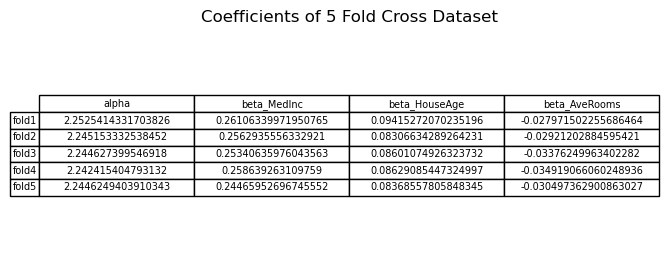

In [143]:

fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the size as needed

ax.axis('off')


col_labels=['alpha','beta_MedInc','beta_HouseAge','beta_AveRooms']
row_labels=['fold1','fold2','fold3','fold4','fold5']

ax.set_title('Coefficients of 5 Fold Cross Dataset')

table = ax.table(cellText=cross_coef, loc='center', cellLoc='center', colLabels =col_labels, rowLabels = row_labels)



plt.show()

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the cross-validated RMSE for each of the 5 folds above. In other words, in fold 1, use the parameters estimated on the 80% of the data to make predictions for the 20%, and calculate the RMSE for those 20%. Repeate this for the remaining folds. Report the RMSE for each of the 5-folds, and the average (mean) RMSE across the five folds. How does this average RMSE compare to the performance of your nearest neighbor algorithm from the last problem set?

In [161]:
cross_RMSE = []
for train, test in kf.split(cal_df['MedHouseVal']):
    standard_x_train = standardize(cal_df[['MedInc','HouseAge','AveRooms']].iloc[train],
                                   cal_df[['MedInc','HouseAge','AveRooms']].iloc[train])
    standard_x_test = standardize(cal_df[['MedInc','HouseAge','AveRooms']].iloc[train],
                                   cal_df[['MedInc','HouseAge','AveRooms']].iloc[test])
 
    reg_temp_alpha,reg_temp_beta = multivariate_ols(standard_x_train.to_numpy(), 
                                                    cal_df['MedHouseVal'].iloc[train].to_numpy(), 
                                                    R = 0.01, MaxIterations = 100000, suppress=True)
    pred_result = reg_temp_alpha + np.dot(standard_x_test,reg_temp_beta)
    
    cross_RMSE.append(compute_rmse(pred_result, 
                                   cal_df['MedHouseVal'].iloc[test].to_numpy().reshape(-1,1)))


print('The RMSE of each of the 5-folds are {}'.format(cross_RMSE))
print('The average RMSE is {}'.format(np.mean(cross_RMSE)))
        

The RMSE of each of the 5-folds are [0.501316554488958, 0.4972505742727483, 0.4857748393579805, 0.4906715917406653, 0.48698074747885745]
The average RMSE is 0.4923988614678419


Compare to what I got in PS3: RMSE = 1.032614, the average RMSE of the gradient descent is much better, it is down by 1/2.

## 4 Regularization 

### 4.1 Get prepped

Step 1: Generate features consisting of all polynomial combinations of degree greater than 0 and less than or equal to 3 of the following features: `MedInc`, `HouseAge` and `AveRooms`. If you are using PolynomialFeatures of sklearn.preprocessing make sure you drop the constant polynomial feature (degree 0). You should have a total of 19 polynomial features. 

Step 2: Randomly sample 80% of your data and call this the training set, and set aside the remaining 20% as your test set.

In [170]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(3, include_bias= False)

features = poly.fit_transform(cal_df[['MedInc','HouseAge','AveRooms']])


In [283]:
x_train, x_test, y_train, y_test = train_test_split(features, cal_df['MedHouseVal'], test_size = 0.2)

### 4.2 Complexity and overfitting?

Now, using your version of multivariate regression from 2.3, let's try to build a more complex model. **Remember to standardize appropriately!** Using the training set, regress the median house value on the polynomial features using your multivariate ols algorithm. Calculate train and test RMSE. Is this the result that you were expecting? How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [173]:
standard_x_train = standardize(x_train,
                               x_train)
standard_x_test = standardize(x_train,
                              x_test)

In [179]:
reg_temp_alpha,reg_temp_beta = multivariate_ols(standard_x_train, 
                                                y_train.to_numpy(),
                                                R = 0.1, MaxIterations = 100000)

Time taken: 172.33 seconds
The algorithm converged in 100000 iterations.


In [207]:
train_pred_result = reg_temp_alpha+ np.dot(standard_x_train, reg_temp_beta)
test_pred_result = reg_temp_alpha+ np.dot(standard_x_test, reg_temp_beta)

print('alpha is {}'.format(reg_temp_alpha))
print('beta is {}'.format(reg_temp_beta.flatten()))
print('train rmse is {}'.format(compute_rmse([element[0] for element in train_pred_result], y_train)))
print('test rmse is {}'.format(compute_rmse([element[0] for element in test_pred_result], y_test)))

alpha is 2.2471219744843243
beta is [-0.75522058  0.50830684  0.09636911  1.46494023  0.60312786 -0.25727956
 -1.36441107 -0.60521563  0.31149533 -0.45475713 -0.47858882  0.11157031
 -0.06130874  0.32876485 -0.08726878  0.81522593  0.2528848   0.30308726
 -0.42875029]
train rmse is 0.47857029607988427
test rmse is 0.4826160910894704


We could see that the RMSE is lower than the RMSE I got from 3.2 and NN, and train RMSE is lower than test RMSE. This is expected as we are now using higher degree of covariates, we have a more complex model. We would decrease the RMSE but potentially lead to overfitting of our data.

### 4.3 Ridge regularization (basic)
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model using all the polynomial features on your training data and using the value lambda = 10^4.  Report the RMSE obtained for your training data, and the RMSE obtained for your testing data.

In [257]:
def multivariate_regularized_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000,lmbda=0, suppress = False):
    start_time = time.time()

    yvalues = yvalues.reshape(-1,1)
    epsilon = 0.0000001

    alpha = np.mean(yvalues)
    beta_array = np.array([[np.mean((yvalues-alpha)/col) for col in xvalue_matrix.T]]).T
    i = 0
    n = len(xvalue_matrix)
    
    while i < MaxIterations:
        alpha_new = alpha - R * np.mean(alpha + np.dot(xvalue_matrix, beta_array) - yvalues)
        beta_array_new = np.empty(beta_array.shape)
        for j in range(len(beta_array)):
            beta_array_new[j] = beta_array[j]*(1-R*lmbda/n) - R * np.mean((alpha + np.dot(xvalue_matrix, beta_array) - yvalues) * xvalue_matrix[:,j].reshape(-1,1))
        
        if (alpha_new-alpha) <= epsilon and np.all((beta_array_new - beta_array) <= epsilon):
            break
        
        alpha = alpha_new
        beta_array = beta_array_new

        i += 1
    
    if  suppress == False:
        print("Time taken: {:.2f} seconds".format(time.time() - start_time))
        print('The algorithm converged in {} iterations.'.format(i))
    
    return alpha, beta_array

In [212]:
reg_temp_alpha,reg_temp_beta = multivariate_regularized_ols(standard_x_train, 
                                                            y_train.to_numpy(),
                                                            R = 0.01, MaxIterations = 10000, lmbda= 10**4)


train_pred_result = reg_temp_alpha+ np.dot(standard_x_train, reg_temp_beta)
test_pred_result = reg_temp_alpha+ np.dot(standard_x_test, reg_temp_beta)


print('alpha is {}'.format(reg_temp_alpha))
print('beta is {}'.format(reg_temp_beta.flatten()))
print('train rmse is {}'.format(compute_rmse([element[0] for element in train_pred_result], y_train)))
print('test rmse is {}'.format(compute_rmse([element[0] for element in test_pred_result], y_test)))



Time taken: 7.43 seconds
The algorithm converged in 511 iterations.
alpha is 2.247121974484321
beta is [ 0.03551562  0.00184318 -0.01025354  0.04209136  0.02071146  0.01511389
  0.00713928 -0.00544406 -0.00595797  0.04542378  0.03199907  0.02952843
  0.01677726  0.0121078  -0.003775    0.01311316  0.0020855  -0.00462175
 -0.00394945]
train rmse is 0.4893827664926361
test rmse is 0.49042607581021797


Now we have RMSE of 0.489 and 0.490, the train RMSE is very close to the test RMSE, suggesting that introducing a ridge penalty term helps alleviates the problem of overfitting.

### 4.4: Cross-validate lambda

This is where it all comes together! Use k-fold cross-validation to select the optimal value of lambda in a regression using all the polynomial features. In other words, define a set of different values of lambda. Then, using the 80% of your data that you set aside for training, iterate through the values of lambda one at a time. For each value of lambda, use k-fold cross-validation to compute the average cross-validated RMSE for that lambda value, computed as the average across the held-out folds. You should also record the average cross-validated train RMSE, computed as the average across the folds used for training. Create a scatter plot that shows RMSE as a function of lambda. The scatter plot should have two lines: a gold line showing the cross-validated RMSE, and a blue line showing the cross-validated train RMSE.  At this point, you should not have touched your held-out 20% of "true" test data.

What value of lambda minimizes your cross-validated RMSE? Fix that value of lambda, and train a new model using all of your training data with that value of lambda (i.e., use the entire 80% of the data that you set aside in 4.1). Calculate the RMSE for this model on the 20% of "true" test data. How does your test RMSE compare to the RMSE from 3.2, 4.2, 4.3 and to the RMSE from nearest neighbors? What do you make of these results? 

Go brag to your friends about how you just implemented cross-validated ridge-regularized multivariate regression using gradient descent optimization, from scratch!

In [250]:
lmbda_range = [10, 10**2, 10**3, 10**4, 10**5, 10**6]

x_train, x_test, y_train, y_test = train_test_split(features, cal_df['MedHouseVal'], test_size = 0.2)

kf = KFold(n_splits=5, shuffle = True)

RMSES = []

In [251]:
for l in lmbda_range:
    train_RMSEs = []
    valid_RMSEs = []
    for train, valid in kf.split(x_train):
        standard_x_train = standardize(x_train[train],
                                       x_train[train])

        standard_x_valid = standardize(x_train[train],
                                       x_train[valid])
 
        cross_y_train = y_train.iloc[train]
        cross_y_valid = y_train.iloc[valid]
        reg_temp_alpha,reg_temp_beta = multivariate_regularized_ols(standard_x_train, 
                                                                    cross_y_train.to_numpy(), 
                                                                    R = 0.01, MaxIterations = 10000, suppress=True, lmbda = l)

        train_pred_result = reg_temp_alpha+ np.dot(standard_x_train, reg_temp_beta)


        valid_pred_result = reg_temp_alpha+ np.dot(standard_x_valid, reg_temp_beta)


        train_RMSEs.append(compute_rmse([element[0] for element in train_pred_result], cross_y_train))
        valid_RMSEs.append(compute_rmse([element[0] for element in valid_pred_result], cross_y_valid))
    RMSES.append([np.mean(train_RMSEs), np.mean(valid_RMSEs)])

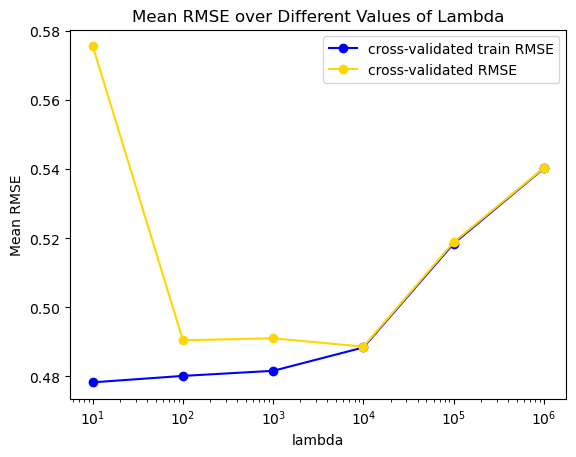

The lambda that minimizes the cross-validated RMSE is 10000


In [276]:
plt.plot(lmbda_range, [rm[0] for rm in RMSES],"o-", color = 'blue', label='cross-validated train RMSE')
plt.plot(lmbda_range, [rm[1] for rm in RMSES],"o-",color = 'gold', label='cross-validated RMSE')

plt.xscale('log')
plt.xlabel('lambda')

plt.ylabel('Mean RMSE')

plt.legend()

plt.title('Mean RMSE over Different Values of Lambda')
plt.show()
best_lambda = lmbda_range[np.argmin([rm[1] for rm in RMSES])]

print('The lambda that minimizes the cross-validated RMSE is {}'.format(best_lambda))

In [289]:
standard_x_train = standardize(x_train,x_train)
standard_x_test = standardize(x_train,x_test)

final_alpha, final_beta = multivariate_regularized_ols(standard_x_train, 
                                                       y_train.to_numpy(), 
                                                       R = 0.01, MaxIterations = 100000, lmbda = best_lambda)

final_pred_result = final_alpha+ np.dot(standard_x_test, final_beta)

test_RMSEs= compute_rmse([element[0] for element in final_pred_result], y_test)
print('The final test RMSE is {}'.format(test_RMSEs))

Time taken: 7.42 seconds
The algorithm converged in 504 iterations.
The final test RMSE is 0.49404450381620096


The final test RMSE is 0.494, which is similar to what I got from 3.2, 4.2 and 4.3, it is still much smaller than the RMSE from NN. This mild difference might be caused by different in max iteration and learning rate.

### 4.5: Compare your results to sklearn ridge [extra-credit]

Repeat your analysis in 4.4, but this time use the sklearn implementation of ridge regression (sklearn.linearmodel.Ridge). Are the results similar? How would you explain the differences, if any?

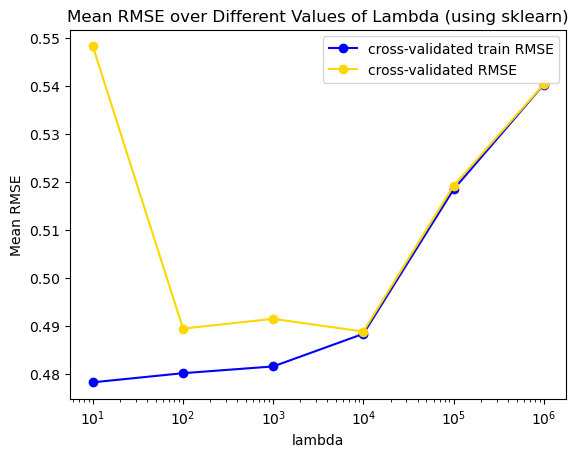

The lambda that minimizes the cross-validated RMSE is 10000


In [280]:
RMSES = []
for l in lmbda_range:
    train_RMSEs = []
    valid_RMSEs = []
    for train, valid in kf.split(x_train):
        standard_x_train = standardize(x_train[train],
                                       x_train[train])

        standard_x_valid = standardize(x_train[train],
                                       x_train[valid])
 
        cross_y_train = y_train.iloc[train]
        cross_y_valid = y_train.iloc[valid]
        ridge = Ridge(alpha=l).fit(standard_x_train, cross_y_train)

        train_pred_result = ridge.predict(standard_x_train)


        valid_pred_result = ridge.predict(standard_x_valid)


        train_RMSEs.append(compute_rmse(train_pred_result, cross_y_train))
        valid_RMSEs.append(compute_rmse(valid_pred_result, cross_y_valid))
    RMSES.append([np.mean(train_RMSEs), np.mean(valid_RMSEs)])

plt.plot(lmbda_range, [rm[0] for rm in RMSES],"o-", color = 'blue', label='cross-validated train RMSE')
plt.plot(lmbda_range, [rm[1] for rm in RMSES],"o-", color = 'gold', label='cross-validated RMSE')

plt.xscale('log')
plt.xlabel('lambda')

plt.ylabel('Mean RMSE')

plt.legend()

plt.title('Mean RMSE over Different Values of Lambda (using sklearn)')
plt.show()

best_lambda = lmbda_range[np.argmin([rm[1] for rm in RMSES])]

print('The lambda that minimizes the cross-validated RMSE is {}'.format(best_lambda))

In [290]:
standard_x_train = standardize(x_train,x_train)
standard_x_test = standardize(x_train,x_test)

ridge = Ridge(alpha=best_lambda).fit(standard_x_train, y_train)

final_pred_result = ridge.predict(standard_x_test)

test_RMSEs= compute_rmse(final_pred_result, y_test)
print('The sklearn test RMSE is {}'.format(test_RMSEs))

The sklearn test RMSE is 0.4940358372925549


The results look very similar to what I got in 4.4, which I would assume that the algorithm I implemented worked well.

### 4.6: AdaGrad [extra-credit]

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in neural network training. Implement AdaGrad on 2.3 using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. Tune the algorithm until you estimate the regression coefficients within a tolerance of 1e-1. Use mini-batch gradient descent in this implementation. In summary for each parameter (in our case one intercept and three slopes) the update step of the gradient (in this example $\beta_j$) at iteration $k$ of the GD algorithm becomes:

$$\beta_j=\beta_j -\frac{R}{\sqrt{G^{(k)}_j}}\frac{\partial J(\alpha,\beta_1,\ldots)}{\partial \beta_j}$$ 
where
$G^{(k)}_j=\sum_{i=1}^{k} (\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j})^2$ and $R$ is your learning rate. The notation $\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j}$ 
corresponds to the value of the gradient at iteration $(i)$. Essentially we are "storing" information about previous iteration gradients. Doing that we effectively decrease the learning rate slower when a feature $x_i$ is sparse (i.e. has many zero values which would lead to zero gradients). Although this method is not necessary for our regression problem, it is good to be familiar with these methods as they are widely used in neural network training.  

In [22]:
# Your code here

*Discuss your results here*